## IMPORT MODULES

In [1]:
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as lda
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import hamming_loss
from time import time
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from pandas import option_context
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import os, pickle, spacy, nltk, re, string, umap, umap.plot
import matplotlib.pyplot as plt
%matplotlib inline  





#nltk.download("stopwords")

import session_info
session_info.show()

## HELPER FUNCTIONS

In [2]:
def load_DataFrame(folder: str, filename: str, print_msg: bool = True):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Load a pandas dataframe from disk that was previously saved
    using the Pickle file format
    ---------------------------------------------------------------------
    
    
    Parameters:
    ---------------------------------------------------------------------
    folder    : the name of the folder to search for file (string)
    filename  : the name of the file to load  (string)
    print_msg : if True, then print the message that the file has been saved
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    df : the pandas dataframe that was previously saved to disk
    
    ---------------------------------------------------------------------
    '''
    df = None
    
    try:
        # Set the filepath
        current_directory = Path(".")
        filepath = os.path.join(current_directory, folder, filename)
        
        with open(filepath, 'rb') as handle:
            df = pickle.load(handle)
        
        if print_msg:
            print(f'Loaded: {filename}')
        
    except:
        print(f'Problem loading :{filename} : \n {filepath}')
        
    return(df)

In [3]:
def show_all_columns(df: pd.DataFrame, rows_to_show: int = 10):
    '''
    Functionality:
    ---------------------------------------------------------------------
    This function will display ALL columns of the dataframe (df), 
    and only the number of rows specified. 
    
    Default number of rows to show = 10
    ---------------------------------------------------------------------
    
    Parameters:
    ---------------------------------------------------------------------
    df           : a pandas dataframe
    rows_to_show : an integer which determines the number of rows to show
    ---------------------------------------------------------------------
    '''
    
    pd.set_option('display.max_columns', None) # change setting to display all columns
    display(df.head(rows_to_show))             # display the dataframe
    pd.reset_option('display.max_columns')     # reset back to normal display setting
    

In [4]:
def is_not_NaN(num):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Checks if the 'num' value is not equal to NaN
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    num : the value to be checked
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    True : if num is not NaN
    False: if num is NaN
    ---------------------------------------------------------------------
    '''
    
    return num == num

In [5]:
def remove_units(df: pd.DataFrame, column_A: str, unit_to_remove: str, add_space: bool = True):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Removes the units (eg. mm) from the values in the specified column
    of the dataframe (df). 
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df             : the pandas dataframe to use
    column_A       : the column within the dataframe to modify
    unit_to_remove : the unit to remove from each value in the column
    add_space      : whether or not to add a space to the unit in question
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    df: the pandas dataframe that has had the units removed.
    ---------------------------------------------------------------------
    '''
    if add_space:
        unit = ' ' + unit_to_remove
    else:
        unit = unit_to_remove
        
    df[column_A] = df[column_A].str.replace(unit, '') 
    return (df)


In [6]:
def fix_column_name(df: pd.DataFrame, column_A: str, unit_to_insert: str):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Inserts the specified unit into the column name of a dataframe (df) 
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df             : the pandas dataframe to use
    column_A       : the column within the dataframe to modify
    unit_to_insert : the unit to insert into the column name
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    df: the pandas dataframe with the new column name
    ---------------------------------------------------------------------
    '''
    df = df.rename(columns = {column_A: f'{column_A} ({unit_to_insert})'})
    return (df)


In [7]:
def fix_power_distance(df: pd.DataFrame):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Converts the 'Total Power' and 'Recommended Viewing Distance' columns
    into ordinal variables to keep some information rather than deleting
    it completely. These columns have many missing values.
    
    The function will also show the effect of the transformation by
    displaying some charts
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df             : the pandas dataframe to fix
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    fix_df: the pandas dataframe with fixed up columns
    ---------------------------------------------------------------------
    '''
    
    # prepare the fix_df and leave the original dataframe untouched
    fix_df = None
    fix_df = df.copy(deep=True)
    
    # Fix the Total Power column
    power_watts = []
    for cell in fix_df['Total Power (Watts)'].apply(pd.to_numeric):
        if cell == 0:
            power_watts.append('not_mentioned')
        elif cell <= 25:
            power_watts.append('low')
        elif cell > 25 and cell <=75:
            power_watts.append('medium')
        elif cell > 75:
            power_watts.append('high')
        else:
            power_watts.append('not_mentioned')
    
    fix_df['Total Power'] = power_watts
    
    
    # Fix the Recommended Viewing Distance Column
    view_distance = []
    for cell in fix_df['Recommended Viewing Distance (cm)'].apply(pd.to_numeric):
        if cell == 0:
            view_distance.append('not_mentioned')
        elif cell <= 160:
            view_distance.append('close')
        elif cell > 160 and cell <=220:
            view_distance.append('normal')
        elif cell > 220:
            view_distance.append('far')
        else:
            view_distance.append('not_mentioned')
    
    fix_df['Viewing Distance'] = view_distance
   
    
    # Show histogram of Total Power (Watts) and Recommended Viewing Distance (cm) before and after transformation
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    fig.tight_layout(pad=3)

    bins = np.linspace(0, 100, 20)
    ax1.hist(fix_df['Total Power (Watts)'].apply(pd.to_numeric),bins, alpha = 0.6, color = 'r')
    ax1.set(title="Total Power", xlabel='Watts', ylabel='Frequency')

    fix_df['Total Power'].value_counts().plot(kind='bar', alpha = 0.4, color = 'r', ax = ax2)
    ax2.set(title="Total Power (after)", ylabel='Frequency')

    bins = np.linspace(100, 400, 20)
    ax3.hist(fix_df['Recommended Viewing Distance (cm)'].apply(pd.to_numeric), alpha = 0.6, color = 'b')
    ax3.set(title="Viewing Distance", xlabel='cm', ylabel='Frequency')

    fix_df['Viewing Distance'].value_counts().plot(kind='bar', alpha = 0.4, color = 'b', ax = ax4)
    ax4.set(title="Viewing Distance (after)", ylabel='Frequency')
    plt.show()  
    
    fix_df = fix_df.drop('Total Power (Watts)', axis = 1)
    fix_df = fix_df.drop('Recommended Viewing Distance (cm)', axis = 1)
    
    return(fix_df)

In [8]:
def restore_reviews(df: pd.DataFrame):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Restores the reviews from a flat form, back to their original form
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df             : the pandas dataframe to extract the reviews from
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    new_df: a pandas dataframe containing reviews in original format
    ---------------------------------------------------------------------
    '''
    ID = []
    Review_num = []
    Review_star_count = []
    Review_customer_name = []
    Review_date = []
    Review_title = []
    Review_text = []
    Review_originally_posted = []
    
    for i in df.index:
        Review_num.extend(df['Review_num'].loc[i].split('<|>'))
        Review_star_count.extend(df['Review_star_count'].loc[i].split('<|>'))   
        Review_customer_name.extend(df['Review_customer_name'].loc[i].split('<|>'))
        Review_date.extend(df['Review_date'].loc[i].split('<|>'))
        Review_title.extend(df['Review_title'].loc[i].split('<|>'))
        Review_text.extend(df['Review_text'].loc[i].split('<|>'))
        Review_originally_posted.extend(df['Review_originally_posted'].loc[i].split('<|>'))
                  
        prod_id = [df['ID'].loc[i]]
        ID.extend((prod_id * len(df['Review_star_count'].loc[i].split('<|>'))))
    
    # Create a new dataframe from the information gathered and return it
    new_df = pd.DataFrame()
    new_df['ID'] = ID
    new_df['Review_num'] = Review_num
    new_df['Review_star_count'] = Review_star_count
    new_df['Review_customer_name'] = Review_customer_name
    new_df['Review_date'] = Review_date
    new_df['Review_title'] = Review_title
    new_df['Review_text'] = Review_text
    new_df['Review_originally_posted'] = Review_originally_posted
    
    return (new_df)

In [41]:
# Function to keep words with tags that are within the list of accepted tokens
def filter_pos(tokens, accepted_tokens):
    return [token if tag in accepted_tokens else '' for token, tag in nltk.pos_tag(tokens)]


# Function that helps to create the n-grams
def generate_N_grams(words,ngram=2):
    # inspired by: https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/
    temp = zip(*[words[i:] for i in range(0,ngram)])
    n_grams = ['_'.join(ngram) for ngram in temp]
    return n_grams


# Function to preprocess the text column of a dataframe
def pre_process(df: pd.DataFrame, text_column: str, n_grams: int = 1, rejoin: bool = True, pos_filter: bool = False):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Pre-process the text column of the dataframe by transforming the text:
    1. convert to lowercase
    2. remove punctuation, numbers and symbols (eg. emojis)
    3. remove excess whitespace
    4. remove stopwords and one letter words
    5. lemmatise
    6. only keep words based on the POS filter (if pos_filter = True)
    7. generate n-grams if n-grams > 1
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df             : the pandas dataframe to transform
    text_column    : the column containing the text to transform
    n_grams        : 1 = unigrams, 2 = bigrams, 3 = trigrams etc
    rejoin         : if True will convert list back to string
    pos_filter     : if True, will keep words that have specified list of POS tags
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    processed_df: a pandas dataframe transformed by the function
    ---------------------------------------------------------------------
    '''
    
    processed_df = None
    processed_df = df.copy(deep=True)
    
    text = {}
    RE_trash = re.compile(r'(\b\w{0,2}\b)|([^a-zA-Z])')
    
    for index, value in processed_df[text_column].items():
        # 1. Lowercase
        value = value.lower()
        
        # 2. remove PUNCTUATION, NUMBERS, SYMBOLS
        value = re.sub(RE_trash, " ", value)
        
        # 3. remove excess WHITESPACE
        value = ' '.join(value.split())
                
        # 4. remove stopwords and one letter words    
        stop_words = set(stopwords.words('english')) - set(['not'])
        value = [word for word in word_tokenize(value) if word not in stop_words and len(word) > 1]
        
        # 5. lemmatise
        value = [WordNetLemmatizer().lemmatize(word) for word in value]
        
        # 6. pos filter
        if pos_filter:
            value = filter_pos(value, ['NN','NNP','NNS','RBR','RBS','JJ','JJR','JJS'])
        
        # 7. Generate n_grams
        if n_grams > 1:
            value = generate_N_grams(value, n_grams)
         
        # join the words back together
        if rejoin:
            value = ' '.join(value)
            value = ' '.join(value.split()) #remove pos filter whitespace
        
        processed_df[text_column].iloc[index] = value
        
    return(processed_df)

In [10]:
def top_10_words(df: pd.DataFrame):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Extracts the Bag of words and their relative counts for each 
    class within a reviews dataframe. 
    
    Will display the first 1000 characters of the BOW
    Will plot the top 10 terms on a bar chart
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df             : the pandas dataframe to extract BOW from
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    BOW: a dictionary containing the bag of words and the term frequency
    ---------------------------------------------------------------------
    '''
    BOW = {}
    
    # Iterate through each class (1-5)
    for i in range(1, 6):
        bow = ' '.join(df.text[df['Review_star_count'] == f'{i}'].tolist()) # bag of words
        tf = Counter(bow.split())                                           # term frequency
        BOW[i] = {'BOW': bow, 'TF': tf}
        
        # Show the first 1000 characters of the BOW
        print(f'BOW {i}-star reviews: \n \n (first thousand characters only) \n \n' , bow[0:1000])
        print('\n')
        
        # Show word cloud - inspired by : https://www.datacamp.com/community/tutorials/wordcloud-python
        wordcloud = WordCloud(background_color="white").generate(bow)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
        print('\n')
        
        # Plot the top 10 most common terms on a bar chart
        # inspired by: https://stackoverflow.com/questions/63018726/counter-and-plot-the-most-common-word-in-a-text
        y = [count for word, count in tf.most_common(10)]
        x = [word for word, count in tf.most_common(10)]
        plt.bar(x, y, color='r', alpha=0.4)
        plt.title(f'Top 10 terms in {i}-Star Reviews')
        plt.ylabel("Frequency")
        plt.xticks(rotation=90)
        for i, (tag, count) in enumerate(tf.most_common(10)):
            plt.text(i, count, f' {count} ', rotation=90, ha='center', va='top', color='black')
        plt.tight_layout() 
        plt.show()

        print('\n')
        print('---------------------------------------------------------------')
        print('\n')
        
    return(BOW)

In [11]:
# Combine the text from specified columns
def combine_columns(df: pd.DataFrame, columns_to_join: list):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Combine the columns specified from a 'reviews' pandas dataframe to
    ensure that all text is in the same column for vectorization
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    df              : the pandas dataframe to perform the action on
    columns_to_join : a list stating the columns you wish to join
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    joined_df: a dataframe with the joined text columns
    ---------------------------------------------------------------------
    '''
    joined_df = None
    joined_df = df.copy(deep=True)
    
    for col in columns_to_join:
        if col == 'Review_title':
            joined_df['text'] = joined_df[col]
        else:
            joined_df['text'] = joined_df['text'].str.cat(joined_df[col],sep=" ")
        joined_df = joined_df.drop(col, axis = 1)

    # Drop the review date column    
    joined_df = joined_df.drop('Review_date', axis = 1)  
    
    return(joined_df)

## LOAD THE MASTER DATAFRAME

In [12]:
folder = 'Product'
filename = 'Master_df.pkl'

# Load the master dataframe into memory
master_df = load_DataFrame(folder, filename)


Loaded: Master_df.pkl


## DATA CLEANING

Create a function to standardise the process of cleaning-up the dataframe.

In [13]:
def clean_dataframe(df: pd.DataFrame):
    '''
    Functionality:
    -------------------------------------------------------------------------------------------------------------
    This function will clean the dataframe (df) by:
    
     - 1. converting price to a numeric value                 (eg.            '$1,455' ---> 1455  ,              )
     - 2. extract original price from 'Original_price'        (eg. '120off RRP of 779' ---> 779   ,              )
     - 3. convert columns 'with ticks' to binary              (eg.             'tick'  --->   1   ,   NaN ---> 0 )
     - 4. extract the number of reviews from 'Review_Count'   (eg.   'from 20 reviews' --->  20   ,  None ---> 0 )
     - 5. remove units from values                            (eg.            '656 mm' ---> 656   ,              )
     - 6. remove repetitive text from EVERY value in the column
     - 7. combine 'Finish Colour' with 'Finish Colour Description'
     - 8. deal with missing values
     - 9. derive new columns based on specific conditions
     - 10. remove unwanted columns  
     - 11. convert some columns to numeric
     - 12. remove products without reviews
     - 13. combine categorical columns   (OPTIONAL??) *********  ******  ******  *********  ******  *********  *******  **********  ************  ************  **********  *********   *******  ********
    -------------------------------------------------------------------------------------------------------------
    
    Parameters:
    -------------------------------------------------------------------------------------------------------------
    df           : a pandas dataframe to be cleaned.
    -------------------------------------------------------------------------------------------------------------
    
    Returns:
    -------------------------------------------------------------------------------------------------------------
    clean_df : a clean dataframe
    -------------------------------------------------------------------------------------------------------------
    '''
    
    # prepare the clean_df and leave the original dataframe untouched
    clean_df = None
    clean_df = df.copy(deep=True)
    
    
    # 1. converting price to a numeric value (eg.'$1,455' ---> 1455)   ------------------------------------------
    clean_df['Price'] = [int(price.replace('$','').replace(',','')) for price in clean_df['Price'] if price is not None]
    
    
    
    # 2. extract original price from 'Original_price' (eg. '$120 off RRP of $779' ---> 779) ---------------------
    clean_df['Original_Price'] = [int(orig_price.replace(',','').split("$")[2]) if orig_price is not None else clean_df.Price.iloc[i] for i, orig_price in enumerate(clean_df['Original_Price'])]
    
    
    
    # 3. convert columns 'with ticks' to binary  (eg.'tick'  --->   1   ,   NaN ---> 0 ) ------------------------
    df_columns = df.columns.tolist()
    tick_columns = df.isin(['tick']).any()
    columns_with_ticks = [feature for feature, has_ticks in zip(df_columns, tick_columns) if has_ticks == True]
    
    for col in columns_with_ticks:
        clean_df.loc[clean_df[col] != 'tick', col] = 0     # does not have a tick
        clean_df.loc[clean_df[col] == 'tick', col] = 1     # has a tick
    
    
    
    
    # 4. extract the number of reviews from 'Review_Count' (eg.'from 20 reviews' --->  20  ,  None ---> 0 ) -----
    clean_df['Review_Count'] = [int(review_count.split(" ")[1]) if review_count is not None else 0 for review_count in clean_df['Review_Count']] 
    
    
    
    
    # 5. remove units from values (eg. '656 mm' ---> 656) -------------------------------------------------------
    # -------------Units removed only
    units_only = {                      'Height (mm)': 'mm',
                                         'Width (mm)': 'mm',
                                         'Depth (mm)': 'mm',
                                        'Weight (kg)': 'Kg',
                              'Manufacturer Warranty': 'Year',
                                        'Screen Size': 'Inch',
                  'Recommended Viewing Distance (cm)': 'cm',
                                         'Brightness': 'Nits',
                              'TV Energy Star Rating': 'Stars',
                                        'Total Power': 'Watts'}

    for key, value in units_only.items():  
        clean_df = remove_units(clean_df, key, value)
    
    # ----------------------Remove residual 's' in this column
    remove_units(clean_df, 'Manufacturer Warranty', 's', False)

    # --------------------Insert units into column names
    units_into_column = {'Manufacturer Warranty': 'Years',
                                   'Screen Size': 'Inches',
                                   'Total Power': 'Watts'}
                    
    for key, value in units_into_column.items():  
        clean_df = fix_column_name(clean_df, key, value)
    
    
    
    
    # 6. remove repetitive text from EVERY value in the column
    clean_df['Review_originally_posted'] = clean_df['Review_originally_posted'].str.replace('Originally posted on ', '', regex=False)
    clean_df['Review_text'] = clean_df['Review_text'].str.replace('[This review was collected as part of a promotion.]', '', regex=False)
    
    
    
    
    # 7. combine 'Finish Colour' with 'Finish Colour Description'  ----------------------------------------------
    new_values = []
    for i, cell in enumerate(clean_df['Finish Colour Description']):
        if isinstance(cell, float):
            new_values.append(clean_df['Finish Colour'][i])
        else:
            new_values.append(cell)

    clean_df['Finish Colour Description'] = new_values   # 'Finish colour' will be deleted in step 10
    
    
    
    
    # 8. deal with missing values -------------------------------------------------------------------------------
    not_mentioned = ['Overview', 'Operating System', 'Processor', 'HDMI Version', 'USB Type', 'Lighting Technology', 
                     'Local Dimming', 'HDCP Version', 'Brightness', 'Accessories included', 'Speaker Channels',
                     'Google Assistant', 'USB Playback Formats']
    
    # Replace some columns with missing values with 'not_mentioned'
    clean_df[not_mentioned] = clean_df[not_mentioned].fillna(value='not_mentioned')
    clean_df['Review_originally_posted'] = clean_df['Review_originally_posted'].fillna(value='appliances online')
    
    
    # Fill the remaining missing values with zero
    clean_df.fillna(value=0, inplace=True) 
    
    
    
    
    # 9. derive new columns based on specific conditions --------------------------------------------------------
    clean_df['Discount'] = [(int(orig) - int(new_price)) for orig, new_price in zip(clean_df['Original_Price'], clean_df['Price'])]
        
    
    
    
    # 10. remove unwanted columns --------------------------------------------------------------------------------
    unwanted_columns = ['Use' , 'Height with Stand', 'Width with Stand', 'Depth with Stand', 'Weight with Stand', 
                        'Stand Size (W x D)','Package Weight (kg)', 'Package Dimensions (H x W x D)', 
                        'Wall Mount Screw Type Required', 'VESA Mount', 'Features', 'Wall Mount Screw Length Required', 
                        'Warranty Note', 'Notes', 'Review_disclaimer_size', 'Finish Colour',
                        'Energy Consumption(kWh/annum)']
                             
    clean_df = clean_df.drop(unwanted_columns, axis = 1)
    
    
    
    
    # 11. Convert some columns to numeric------------------------------------------------------------------------
    convert_to_numeric = ['Height (mm)', 'Width (mm)', 'Depth (mm)', 'Weight (kg)', 'Manufacturer Warranty (Years)', 
                          'Screen Size (Inches)', 'USB Ports', 'HDMI Ports (IN)'] 
    clean_df[convert_to_numeric] = clean_df[convert_to_numeric].apply(pd.to_numeric)
    
    
    
    # 12. Remove products without reviews
    clean_df = clean_df[clean_df['Review_star_count'] != 0]
    clean_df.reset_index(drop=True, inplace=True)
    
    
    
    # 13. combine categorical columns ---------------------------------------------------------------------------
    print("The dataset has been cleaned !")
    return(clean_df)

    


## Clean the master dataset

In [14]:
master_df_cleaned = clean_dataframe(master_df)

The dataset has been cleaned !


## DIVIDE THE MASTER DATAFRAME - TRAIN / TEST

    
 - **Split into Training and Testing Sets**
     - Training set (80%) : Testing set (20%) split
     - using random_state = 19 - for reproducibility<br>


In [ ]:
# TRAIN / TEST SPLIT : get the indices for training and testing (80% train, 20% test)
training_index, testing_index = train_test_split(master_df_cleaned.index, train_size=0.8, random_state=19)

#Show the number of products selected for training and testing
print('-----------------------------------------------')
print(f'Training Index Shape: {training_index.shape}')
print(f'Testing Index Shape: {testing_index.shape}')   
print('')

# Create the training set using the training_index (and display the first two rows of the training set)
training_set = master_df_cleaned.iloc[training_index, :]
training_set.reset_index(drop=True, inplace=True)

# Hold the testing set for later testing
testing_set = master_df_cleaned.iloc[testing_index, :]
testing_set.reset_index(drop=True, inplace=True)

## EXPLORATORY DATA ANALYSIS

### Training set columns

In [16]:
training_set_columns = training_set.columns.tolist()
print(training_set_columns)

['ID', 'Product_Name', 'Product_Link', 'Price', 'Review_Count', 'Review_Score', 'Original_Price', 'Overview', 'Brand', 'Model Number', 'Finish Colour Description', 'Height (mm)', 'Width (mm)', 'Depth (mm)', 'Weight (kg)', 'Accessories included', 'Manufacturer Warranty (Years)', 'Screen Technology', 'Screen Size (Inches)', 'HD Type', 'Wide Colour Gamut', 'Recommended Viewing Distance (cm)', 'Speaker Channels', 'Total Power (Watts)', 'High Dynamic Range (HDR)', 'HDR10+', 'Upscaling', 'USB File Playback', 'Google Assistant', 'Amazon Alexa Compatible', 'Bixby', 'SmartThings', 'AirPlay2', 'Operating System', 'Processor', 'FreeView+ Compatibility', 'Netflix Compatibility', 'Stan Compatibility', 'Apps', 'Streaming Services', 'Android App', 'Display Mirroring', 'Bluetooth', 'Ethernet', 'WiFi', 'Composite In', 'HDMI Ports (IN)', 'HDMI Version', 'HDMI-eARC', 'HDMI-CEC', 'RF Connection In', 'USB Ports', 'USB Type', 'Digital Optical Audio Out', 'TV Energy Star Rating', 'Year', '1_star', '2_star', 

### Show first two rows of TRAINING SET

In [17]:
show_all_columns(training_set, 2)

,ID,Product_Name,Product_Link,Price,Review_Count,Review_Score,Original_Price,Overview,Brand,Model Number,Finish Colour Description,Height (mm),Width (mm),Depth (mm),Weight (kg),Accessories included,Manufacturer Warranty (Years),Screen Technology,Screen Size (Inches),HD Type,Wide Colour Gamut,Recommended Viewing Distance (cm),Speaker Channels,Total Power (Watts),High Dynamic Range (HDR),HDR10+,Upscaling,USB File Playback,Google Assistant,Amazon Alexa Compatible,Bixby,SmartThings,AirPlay2,Operating System,Processor,FreeView+ Compatibility,Netflix Compatibility,Stan Compatibility,Apps,Streaming Services,Android App,Display Mirroring,Bluetooth,Ethernet,WiFi,Composite In,HDMI Ports (IN),HDMI Version,HDMI-eARC,HDMI-CEC,RF Connection In,USB Ports,USB Type,Digital Optical Audio Out,TV Energy Star Rating,Year,1_star,2_star,3_star,4_star,5_star,Review_flat_count,Review_flat_1_star,Review_flat_2_star,Review_flat_3_star,Review_flat_4_star,Review_flat_5_star,Review_flat_avg_star,Review_num,Review_star_count,Review_customer_name,Review_date,Review_title,Review_text,Review_originally_posted,Lighting Technology,Local Dimming,Dolby Vision,Chromecast,Airplay,Voice Control,HDCP Version,Headphone Out,HDMI-ARC,Brightness,USB Playback Formats,iOS App,Network File Sharing,Component In,AUX In,Motion Control,Digital Optical Audio In,Curved,Discount
0,00002,Samsung 65 Inch Q70A 4K UHD QLED Smart TV QA65...,https://www.appliancesonline.com.au/product/sa...,2198,1320,4.8,2799,"Captivating and alluring, the Samsung 65 Inch ...",Samsung,QA65Q70AAWXXY,Titan Grey bezel with Sand Black stand,897.8,1451.7,25.7,20.9,"Remote control, Batteries, Quick start guide",1,QLED .,65,Ultra HD- 4K,1,195,2 Ch,20,1,1,1,1,Compatible,1,1,1,1,Tizen,Quantum Processor 4K,1,1,1,1,1,1,1,1,1,1,1,4,2.1,1,1,1,2,2,1,4.0,2021,5.0,6.0,25.0,176.0,1108.0,314.0,0.0,1.0,7.0,35.0,271.0,4.83,00005<|>00009<|>00011<|>00013<|>00014<|>00019<...,5<|>5<|>5<|>5<|>5<|>5<|>5<|>5<|>5<|>4<|>5<|>5<...,FoxyRoxy520<|>Tj13kaz<|>Gruja<|>Bonzo<|>Quan<|...,2021-10-19<|>2021-10-19<|>2021-10-19<|>2021-10...,Love it <|> Easy set up great picture <|> Ama...,The picture quality is absolutely amazing! O...,Samsung US.<|> Samsung US.<|> Samsung US.<|> ...,not_mentioned,not_mentioned,0,0,0,0,not_mentioned,0,0,not_mentioned,not_mentioned,0,0,0,0,0,0,0,601
1,00043,Sony 65 Inch A90J Master Series 4K UHD HDR OLE...,https://www.appliancesonline.com.au/product/so...,5156,201,4.6,5499,not_mentioned,Sony,XR65A90J,Black,833.0,1444.0,41.0,22.5,"Remote Control, Batteries, User Manual",1,OLED .,65,Ultra HD- 4K,1,195,not_mentioned,0,1,0,1,1,Built In,1,0,0,0,Google TV,Cognitive Processor XR,1,1,1,1,1,1,1,1,1,1,1,4,2.0,1,1,1,2,2.0,1,4.5,2021,5.0,4.0,12.0,24.0,156.0,99.0,2.0,1.0,4.0,13.0,79.0,4.68,00002<|>00003<|>00005<|>00006<|>00009<|>00010<...,5<|>5<|>1<|>5<|>5<|>4<|>4<|>2<|>5<|>5<|>5<|>5<...,Old_Sequoia<|>Mart The Tart<|>LULUM<|>Craig007...,2021-11-27<|>2021-11-26<|>2021-11-18<|>2021-11...,Best TV I’ve ever bought <|> What a piece of ...,Had a few Sony’s but I think that this is the...,sony.com.<|> sony.com.<|> sony.com.<|> Sony.c...,Self Emitting,Yes,1,1,1,1,2.3,1,0,not_mentioned,not_mentioned,0,0,0,0,0,0,0,343


### Missing values

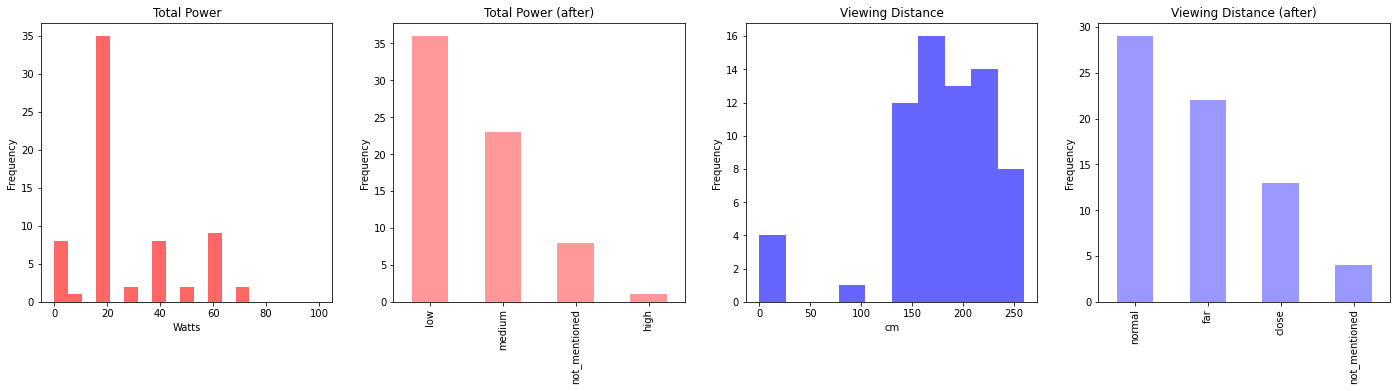




Shape of the TRAINING SET: (68, 94)


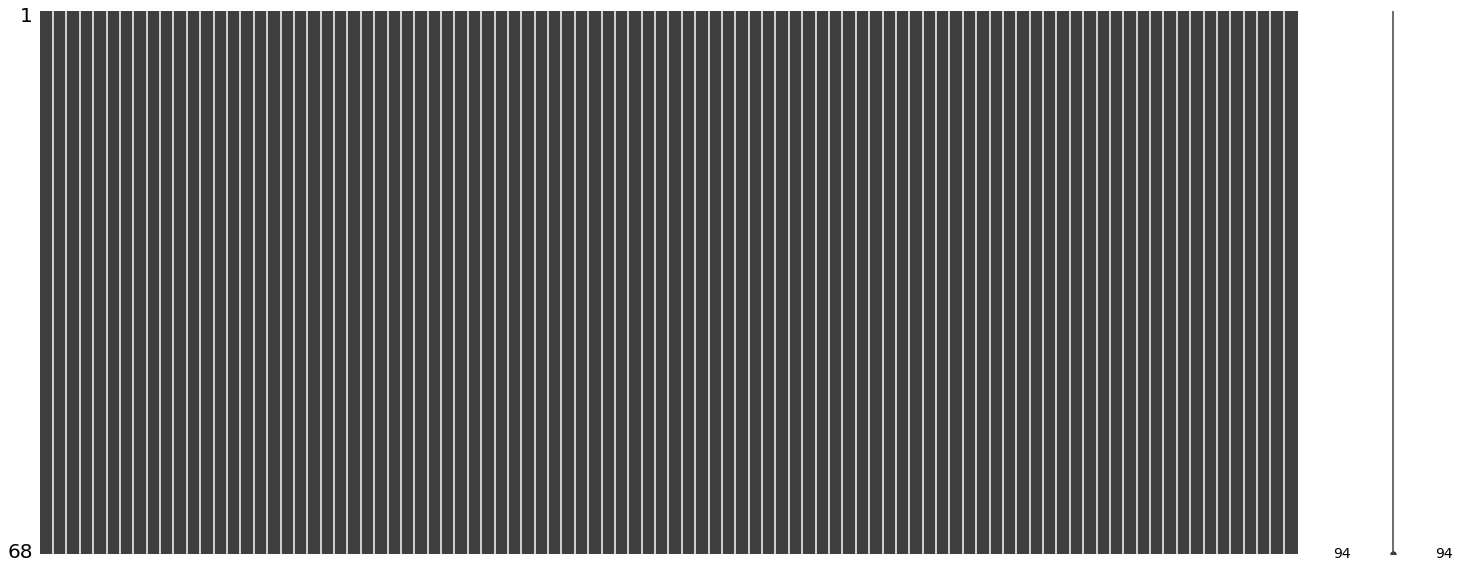

In [18]:
# Total Power and Viewing Distance Columns have many missing values.  
# Will convert to an ordinal variable to maintain some information rather than remove it
training_set = fix_power_distance(training_set)

# Show the number of rows and columns of the training set
print('\n\n')
print(f'Shape of the TRAINING SET: {training_set.shape}')

# Check if there are any missing values in the training set
msno.matrix(training_set)
plt.show()

## Descriptive statistics for the numeric variables

In [19]:
show_all_columns(training_set.describe(include=[np.number]).round(2))

,Price,Review_Count,Original_Price,Height (mm),Width (mm),Depth (mm),Weight (kg),Manufacturer Warranty (Years),Screen Size (Inches),Wide Colour Gamut,High Dynamic Range (HDR),HDR10+,Upscaling,USB File Playback,Amazon Alexa Compatible,Bixby,SmartThings,AirPlay2,FreeView+ Compatibility,Netflix Compatibility,Stan Compatibility,Apps,Streaming Services,Android App,Display Mirroring,Bluetooth,Ethernet,WiFi,Composite In,HDMI Ports (IN),HDMI-eARC,HDMI-CEC,RF Connection In,USB Ports,Digital Optical Audio Out,1_star,2_star,3_star,4_star,5_star,Review_flat_count,Review_flat_1_star,Review_flat_2_star,Review_flat_3_star,Review_flat_4_star,Review_flat_5_star,Review_flat_avg_star,Dolby Vision,Chromecast,Airplay,Voice Control,Headphone Out,HDMI-ARC,iOS App,Network File Sharing,Component In,AUX In,Motion Control,Digital Optical Audio In,Curved,Discount
count,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.0,68.00,68.00,68.00,68.00,68.00,68.00,68.0,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.00,68.0,68.00,68.00,68.00
mean,3375.94,434.81,3612.35,820.48,1420.61,60.85,24.24,1.21,63.53,0.60,0.94,0.37,0.91,0.99,0.78,0.34,0.34,0.34,0.91,0.96,0.94,0.96,0.96,0.66,0.76,0.75,0.99,1.0,0.75,3.66,0.82,0.96,0.97,2.21,1.0,5.07,4.63,13.43,65.25,346.43,111.76,1.24,1.31,3.53,16.51,89.18,4.54,0.49,0.34,0.47,0.60,0.57,0.13,0.06,0.07,0.09,0.01,0.0,0.01,0.01,236.41
std,2900.66,533.48,2971.77,172.93,304.30,77.24,12.90,0.61,13.76,0.49,0.24,0.49,0.29,0.12,0.42,0.48,0.48,0.48,0.29,0.21,0.24,0.21,0.21,0.48,0.43,0.44,0.12,0.0,0.44,0.56,0.38,0.21,0.17,0.48,0.0,4.24,4.85,17.36,79.37,432.90,145.09,1.49,2.08,4.70,20.69,119.10,0.41,0.50,0.48,0.50,0.49,0.50,0.34,0.24,0.26,0.29,0.12,0.0,0.12,0.12,313.98
min,314.00,1.00,399.00,426.00,722.00,17.20,0.00,1.00,32.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,2.00,0.00,0.00,0.00,1.00,1.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
25%,1653.75,21.75,1696.50,708.28,1227.90,26.90,15.50,1.00,55.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.75,1.00,1.0,0.75,3.00,1.00,1.00,1.00,2.00,1.0,1.00,0.00,1.00,2.00,15.75,6.00,0.00,0.00,0.00,1.00,5.00,4.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
50%,2507.50,125.00,2749.00,831.80,1448.00,53.50,21.25,1.00,65.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,4.00,1.00,1.00,1.00,2.00,1.0,5.00,4.00,5.00,23.00,98.00,27.50,1.00,1.00,1.00,5.50,22.50,4.67,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,105.00
75%,3914.00,773.50,4106.50,961.08,1673.95,70.25,32.10,1.00,75.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,4.00,1.00,1.00,1.00,2.00,1.0,9.00,6.25,23.50,106.00,630.50,194.50,2.00,2.00,6.00,27.00,157.00,4.76,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,349.25
max,15839.00,1694.00,15999.00,1125.00,1927.00,660.00,61.70,3.00,86.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,4.00,1.00,1.00,1.00,4.00,1.0,12.00,15.00,59.00,264.00,1360.00,569.00,7.00,14.00,23.00,71.00,477.00,5.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,1.00,1.00,1490.00


## Descriptive statistics for the categorical variables

In [20]:
show_all_columns(training_set.describe(exclude=[np.number]).round(2))

,ID,Product_Name,Product_Link,Review_Score,Overview,Brand,Model Number,Finish Colour Description,Accessories included,Screen Technology,HD Type,Speaker Channels,Google Assistant,Operating System,Processor,HDMI Version,USB Type,TV Energy Star Rating,Year,Review_num,Review_star_count,Review_customer_name,Review_date,Review_title,Review_text,Review_originally_posted,Lighting Technology,Local Dimming,HDCP Version,Brightness,USB Playback Formats,Total Power,Viewing Distance
count,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68
unique,68,68,68,10,59,7,68,12,12,6,5,8,3,8,12,3,3,10,6,62,66,68,68,68,68,65,6,3,4,5,4,4,4
top,00002,Samsung 65 Inch Q70A 4K UHD QLED Smart TV QA65...,https://www.appliancesonline.com.au/product/sa...,4.7,not_mentioned,Samsung,QA65Q70AAWXXY,Black,"Remote Control, Batteries, User Manual",LED .,Ultra HD- 4K,2 Ch,Compatible,Tizen,Cognitive Processor XR,2.0,2.0,4.0,2021,00000<|>00001<|>00002<|>00003<|>00004<|>00005<...,5<|>5<|>5<|>5,FoxyRoxy520<|>Tj13kaz<|>Gruja<|>Bonzo<|>Quan<|...,2021-10-19<|>2021-10-19<|>2021-10-19<|>2021-10...,Love it <|> Easy set up great picture <|> Ama...,The picture quality is absolutely amazing! O...,Sony.com.au.,not_mentioned,not_mentioned,not_mentioned,not_mentioned,not_mentioned,low,normal
freq,1,1,1,18,10,27,1,40,22,36,61,30,39,24,11,31,29,18,58,3,2,1,1,1,1,2,36,41,27,64,64,36,29


# <u> NLP TASK 1 : </u>

## SENTIMENT ANALYSIS OF REVIEWS

#### Show Reviews for each product

In [21]:
review_columns = ['ID','Review_num', 'Review_star_count','Review_customer_name','Review_date','Review_title','Review_text','Review_originally_posted']

training_set_reviews = training_set.filter(items=review_columns)
display(training_set_reviews.head(2))    

,ID,Review_num,Review_star_count,Review_customer_name,Review_date,Review_title,Review_text,Review_originally_posted
0,00002,00005<|>00009<|>00011<|>00013<|>00014<|>00019<...,5<|>5<|>5<|>5<|>5<|>5<|>5<|>5<|>5<|>4<|>5<|>5<...,FoxyRoxy520<|>Tj13kaz<|>Gruja<|>Bonzo<|>Quan<|...,2021-10-19<|>2021-10-19<|>2021-10-19<|>2021-10...,Love it <|> Easy set up great picture <|> Ama...,The picture quality is absolutely amazing! O...,Samsung US.<|> Samsung US.<|> Samsung US.<|> ...
1,00043,00002<|>00003<|>00005<|>00006<|>00009<|>00010<...,5<|>5<|>1<|>5<|>5<|>4<|>4<|>2<|>5<|>5<|>5<|>5<...,Old_Sequoia<|>Mart The Tart<|>LULUM<|>Craig007...,2021-11-27<|>2021-11-26<|>2021-11-18<|>2021-11...,Best TV I’ve ever bought <|> What a piece of ...,Had a few Sony’s but I think that this is the...,sony.com.<|> sony.com.<|> sony.com.<|> Sony.c...


#### Transform TRAINING SET reviews back to normal format

In [22]:
training_set_reviews = restore_reviews(training_set_reviews)
display(training_set_reviews)

,ID,Review_num,Review_star_count,Review_customer_name,Review_date,Review_title,Review_text,Review_originally_posted
0,00002,00005,5,FoxyRoxy520,2021-10-19,Love it,The picture quality is absolutely amazing! O...,Samsung US.
1,00002,00009,5,Tj13kaz,2021-10-19,Easy set up great picture,"1 screen does it all gaming, monitor for wor...",Samsung US.
2,00002,00011,5,Gruja,2021-10-19,"Amazing picture, good sound, great design","Bought this TV last week, I'm very satisfied...",Samsung US.
3,00002,00013,5,Bonzo,2021-10-18,One of the best!,I have owned Samsung televisions for close t...,Samsung US.
4,00002,00014,5,Quan,2021-10-18,Pic.in pic voice ckmmands,I use it for gaming movies i love useing bix...,Samsung US.
...,...,...,...,...,...,...,...,...
7595,00040,00034,5,Hunk15,2021-10-09,Great picture,"Bought this three weeks ago, this is my first...",lg.com/uk.
7596,00040,00036,5,KUSHY,2021-09-22,Great for gaming 120fps,Outstanding tv for gaming and movies bright e...,lg.com/uk.
7597,00040,00038,1,Kurdt3000,2021-09-11,Poor sound optical socket feel out of tv,Don’t buy this tv is rubbish sound is terribl...,lg.com/uk.
7598,00040,00042,5,Kingferouk,2021-09-01,Great LG OLED TV,Bought an OLED65B16LA TV for my living room r...,lg.com/uk.


### Combine text columns of the TRAINING SET

In [23]:
columns_to_join = ['Review_title','Review_text','Review_originally_posted']
training_set_reviews = combine_columns(training_set_reviews, columns_to_join)

# Display the training_set_reviews dataframe
with option_context('display.max_colwidth', 200):
    display(training_set_reviews.head(2))

,ID,Review_num,Review_star_count,Review_customer_name,text
0,00002,00005,5,FoxyRoxy520,"Love it The picture quality is absolutely amazing! Out of all the different brands I have ever owned, Samsung hands down has the most vibrant picture. It also streams any video or movie seamle..."
1,00002,00009,5,Tj13kaz,"Easy set up great picture 1 screen does it all gaming, monitor for work and cartoons for the kids 1 word ""complete"" Samsung US."


### Examine the stars per review in the TRAINING SET

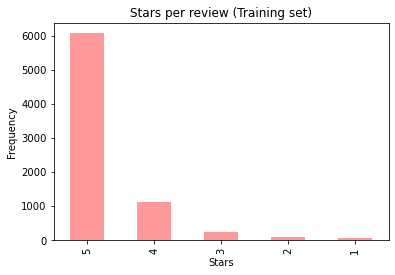

In [24]:
training_set_reviews['Review_star_count'].value_counts().plot(kind='bar', alpha=0.4, color='r', title='Stars per review (Training set)', xlabel="Stars", ylabel="Frequency")
plt.show()

### Pre-processing text column of the TRAINING SET

In [25]:
#-------------------------------------------------------------------------------
# Pre-process the training set - returning UNIGRAMS
training_1 = pre_process(training_set_reviews, text_column = 'text', n_grams = 1)
print("Training Set Unigrams")
with option_context('display.max_colwidth', 200):
    display(training_1.head(2))   

# Pre-process the training set - returning BIGRAMS
training_2 = pre_process(training_set_reviews, text_column = 'text', n_grams = 2)
print("Training Set Bigrams")
with option_context('display.max_colwidth', 200):
    display(training_2.head(2))   



Training Set Unigrams


,ID,Review_num,Review_star_count,Review_customer_name,text
0,00002,00005,5,FoxyRoxy520,love picture quality absolutely amazing different brand ever owned samsung hand vibrant picture also stream video movie seamlesly samsung
1,00002,00009,5,Tj13kaz,easy set great picture screen gaming monitor work cartoon kid word complete samsung


Training Set Bigrams


,ID,Review_num,Review_star_count,Review_customer_name,text
0,00002,00005,5,FoxyRoxy520,love_picture picture_quality quality_absolutely absolutely_amazing amazing_different different_brand brand_ever ever_owned owned_samsung samsung_hand hand_vibrant vibrant_picture picture_also also...
1,00002,00009,5,Tj13kaz,easy_set set_great great_picture picture_screen screen_gaming gaming_monitor monitor_work work_cartoon cartoon_kid kid_word word_complete complete_samsung


### TOP 10 BIGRAMS in each class of the TRAINING SET

BOW 1-star reviews: 
 
 (first thousand characters only) 
 
 worst_ever ever_owned owned_iplayer iplayer_itv itv_hub hub_etc etc_sound sound_keep keep_failing failing_arc arc_mode mode_intermittent intermittent_fault fault_difficult difficult_get get_resolved resolved_periodically periodically_switch switch_google google_reason reason_take take_get get_back back_hate hate_hate hate_hate hate_wish wish_never never_bought bought_used used_trust trust_sony sony_not not_sony sony_com missing_key key_advertised advertised_feature feature_expensive expensive_doorstop doorstop_avoid avoid_not not_ship ship_youview youview_catch catch_apps apps_thus thus_fundamentally fundamentally_fails fails_core core_purpose purpose_provide provide_sony sony_not not_state state_date date_advertised advertised_feature feature_added added_like like_selling selling_car car_without without_engine engine_sony sony_com lasted_month month_using using_afterwork afterwork_month month_broken broken_samsung samsung_ev

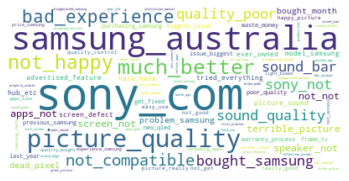

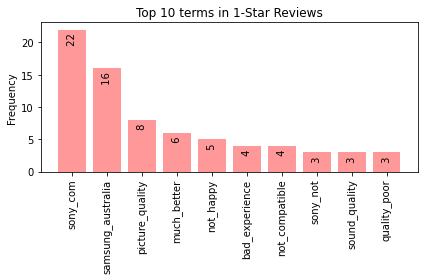



---------------------------------------------------------------


BOW 2-star reviews: 
 
 (first thousand characters only) 
 
 disappointed_spent spent_extra extra_thinking thinking_going going_get get_better better_sound sound_match match_picture picture_samsung samsung_repair repair_service service_come come_cable cable_company company_come come_still still_fix fix_finally finally_one one_samsung samsung_called called_sent sent_software software_update update_fixed fixed_problem problem_somewhat somewhat_sometimes sometimes_voice voice_still still_match match_picture picture_not not_happy happy_samsung picture_great great_quality quality_case case_shocking shocking_picture picture_great great_sound sound_good good_quality quality_case case_surround surround_manufacture manufacture_attention attention_detail detail_shocking shocking_previous previous_two two_sonys sonys_much much_cheaper cheaper_quality quality_case case_surround surround_looked looked_good good_one one_plasticky pl

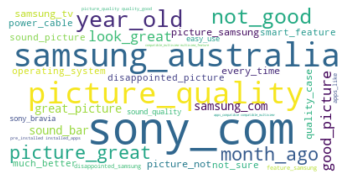

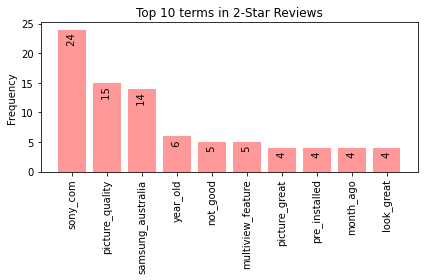



---------------------------------------------------------------


BOW 3-star reviews: 
 
 (first thousand characters only) 
 
 football_football football_season season_back back_recently recently_moving moving_needed needed_living living_room room_went went_inch inch_perfect perfect_open open_living living_room room_kitchen kitchen_area area_glare glare_not not_bad bad_either either_samsung product_way way_world world_probably probably_smartest smartest_think think_ever ever_date date_samsung good_not not_great great_definitely definitely_could could_better better_bought bought_month month_back back_overall overall_job job_rate rate_best best_specially specially_usability usability_perspective perspective_definitely definitely_improved improved_using using_arrow arrow_key key_premitive premitive_typing typing_youtube youtube_search search_keyword keyword_cumbersome cumbersome_lot lot_better better_job job_term term_plus plus_remote remote_solar solar_powered powered_remote remote_run

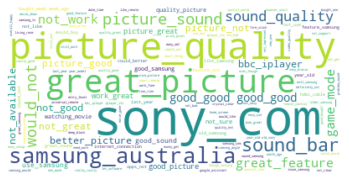

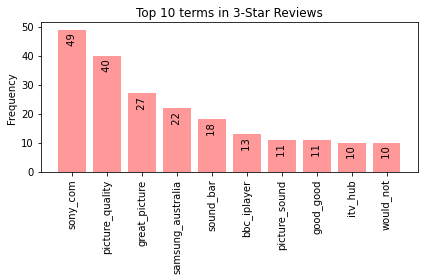



---------------------------------------------------------------


BOW 4-star reviews: 
 
 (first thousand characters only) 
 
 groovy_tellie tellie_far far_love love_sure sure_like like_better better_becomes becomes_widespread widespread_thing thing_picture picture_look look_crisp crisp_old old_could could_difference difference_station station_samsung customizable_feature feature_mounted mounted_tbe tbe_wall wall_family family_room room_used used_view view_dvd dvd_movie movie_weekend weekend_great great_picture picture_quality quality_also also_used used_watch watch_many many_sporting sporting_event event_well well_general general_show show_still still_learning learning_use use_airplay airplay_samsung samsungs_graphic graphic_unparalleled unparalleled_mainly mainly_us us_streaming streaming_live live_youtube youtube_like like_also also_son son_us us_p p_game game_system system_great great_grafics grafics_refresh refresh_rate rate_win win_samsung picture_clear clear_use use_smart smar

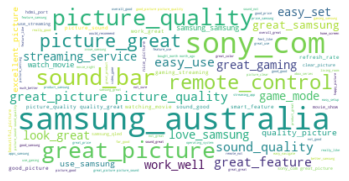

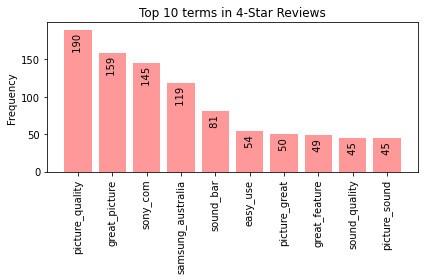



---------------------------------------------------------------


BOW 5-star reviews: 
 
 (first thousand characters only) 
 
 love_picture picture_quality quality_absolutely absolutely_amazing amazing_different different_brand brand_ever ever_owned owned_samsung samsung_hand hand_vibrant vibrant_picture picture_also also_stream stream_video video_movie movie_seamlesly seamlesly_samsung easy_set set_great great_picture picture_screen screen_gaming gaming_monitor monitor_work work_cartoon cartoon_kid kid_word word_complete complete_samsung amazing_picture picture_good good_sound sound_great great_design design_bought bought_last last_week week_satisfied satisfied_specially specially_amazing amazing_picture picture_colour colour_balance balance_great great_wireless wireless_conectivity conectivity_samsung samsung_note note_cellphone cellphone_using using_wifi wifi_samsung samsung_dex dex_also also_solar solar_usb usb_charging charging_remote remote_great great_well well_tizen tizen_wor

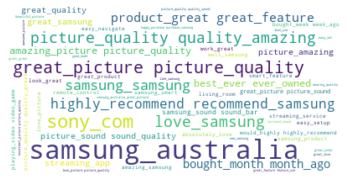

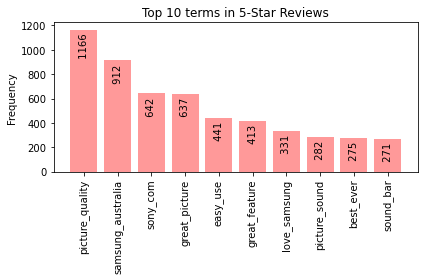



---------------------------------------------------------------




In [26]:
#Get the top 10 bigrams for each class
BOW_bigrams = top_10_words(training_2)

### Vectorize the feature column

In [27]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

X_train = training_2['text']
y_train = training_2['Review_star_count']

X_train_vect = vectorizer.fit_transform(X_train)

# Show the vectorised version of X
feature_names = vectorizer.get_feature_names_out()
X_train_vect_df = pd.DataFrame(data=X_train_vect.toarray(), columns=feature_names).iloc[:,0::2]
display(X_train_vect_df)

,aa_like,aa_samsung,aaa_battery,aaf_color,aafxza_say,aafxza_wife,ab_easy,abandoned_sony,abc_cetera,abc_nbc,...,zone_tackle,zoom_business,zoom_comp,zoom_day,zoom_give,zoom_like,zoom_meeting,zoom_picture,zoom_television,zoomed_way
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TRAIN THE MODEL - KNN Classifier

In [28]:
t0 = time()
# KNN Model Classifier
model = KNeighborsClassifier(n_neighbors=5)

# Train the model using the TRAINING SET
model.fit(X_train_vect, y_train)

# Display the time taken to train the model
print(f'\nTraining time: {round(time()-t0, 3)}s')
t0 = time()

# Make predictions using the training set
training_preds = model.score(X_train_vect.toarray(), y_train)

# Display the time taken to make predictions
print(f'Prediction time (train): {round(time()-t0, 3)}s')
t0 = time()

# Show the accuracy of the model on training data
print('\nTrain set score:', training_preds)


Training time: 0.008s
Prediction time (train): 17.68s

Train set score: 0.8214473684210526


### MODEL TUNING - perform Stratified 5-fold cross validation using the TRAINING set

In [29]:
# KNN classifier
model_for_tuning = KNeighborsClassifier()

# Set the parameters
param_grid = {'n_neighbors': [5,6],
                  'weights': ['distance'],
                'leaf_size': [5,10,15],
                        'p': [2]} 
 

# Tune the model: use HalvingGridSearch method, #StratifiedKFold is used.
h_grid = HalvingGridSearchCV(model_for_tuning, 
                             param_grid, 
                             cv=5,
                             refit = True,
                             n_jobs=-1, 
                             verbose = 10, 
                             max_resources=50
                            ).fit(X_train_vect.toarray(), y_train)


# Display the best parameters
h_grid.best_estimator_


n_iterations: 1
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 50
max_resources_: 50
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 50
Fitting 5 folds for each of 6 candidates, totalling 30 fits


KNeighborsClassifier(leaf_size=5, n_neighbors=6, weights='distance')

### BEST MODEL and RESULTS

In [30]:
df_results = pd.DataFrame(h_grid.cv_results_)
best = df_results.loc[h_grid.best_index_]

show_all_columns(best)
show_all_columns(df_results, 100)

iter                        0
n_resources                50
mean_fit_time        0.041919
std_fit_time         0.003613
mean_score_time      0.041633
std_score_time       0.016459
param_leaf_size             5
param_n_neighbors           6
param_p                     2
param_weights        distance
Name: 1, dtype: object

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,50,0.042990,0.003487,0.059288,0.007243,5,5,2,distance,"{'leaf_size': 5, 'n_neighbors': 5, 'p': 2, 'we...",0.7,0.5,0.7,0.7,0.8,0.68,0.097980,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0,50,0.041919,0.003613,0.041633,0.016459,5,6,2,distance,"{'leaf_size': 5, 'n_neighbors': 6, 'p': 2, 'we...",0.7,0.5,0.8,0.7,0.8,0.70,0.109545,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0,50,0.055850,0.001669,0.039098,0.010410,10,5,2,distance,"{'leaf_size': 10, 'n_neighbors': 5, 'p': 2, 'w...",0.7,0.5,0.7,0.7,0.8,0.68,0.097980,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0,50,0.049265,0.004944,0.032247,0.001364,10,6,2,distance,"{'leaf_size': 10, 'n_neighbors': 6, 'p': 2, 'w...",0.7,0.5,0.8,0.7,0.8,0.70,0.109545,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0,50,0.048862,0.007267,0.046866,0.009878,15,5,2,distance,"{'leaf_size': 15, 'n_neighbors': 5, 'p': 2, 'w...",0.7,0.5,0.7,0.7,0.8,0.68,0.097980,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0,50,0.054884,0.008080,0.023167,0.004901,15,6,2,distance,"{'leaf_size': 15, 'n_neighbors': 6, 'p': 2, 'w...",0.7,0.5,0.8,0.7,0.8,0.70,0.109545,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


### TESTING SET PREPARATION

In [31]:
# Process the testing set
#testing_set = fix_power_distance(testing_set)
testing_set_reviews = testing_set.filter(items=review_columns)
testing_set_reviews = restore_reviews(testing_set_reviews)
testing_set_reviews = combine_columns(testing_set_reviews, columns_to_join)
testing_2 = pre_process(testing_set_reviews, text_column = 'text', n_grams=2)

### PREDICT on the TESTING SET (base model)

In [32]:
# Select the predictor and response variables from the TESTING set
X_test = testing_2['text']
y_test = testing_2['Review_star_count']

# Vectorize the predictor variable (X)
X_test_vect = vectorizer.transform(X_test)

# Make predictions using the original model (trained earlier)
t0 = time()
y_pred = model.predict(X_test_vect.toarray())

# Show the time taken to make the prediction
print(f'Prediction time (test): {round(time()-t0, 3)}s')

# Show the statistics of the prediction
print(classification_report(y_test, y_pred, zero_division=0))

# Show the hamming loss
print(f'Hamming loss: {hamming_loss(y_test, y_pred)}')

# Show the log-loss
pred_probs = model.predict_proba(X_test_vect.toarray())
print(f'Log loss: {log_loss(y_test, pred_probs)}')


Prediction time (test): 1.711s
              precision    recall  f1-score   support

           1       0.50      0.11      0.18        18
           2       0.00      0.00      0.00        11
           3       0.29      0.05      0.09        37
           4       0.30      0.06      0.11       188
           5       0.81      0.98      0.89       979

    accuracy                           0.79      1233
   macro avg       0.38      0.24      0.25      1233
weighted avg       0.71      0.79      0.73      1233

Hamming loss: 0.21005677210056772
Log loss: 3.8675074593577237


### PREDICT using the TUNED MODEL

              precision    recall  f1-score   support

           1       0.50      0.11      0.18        18
           2       0.00      0.00      0.00        11
           3       0.43      0.08      0.14        37
           4       0.38      0.07      0.12       188
           5       0.81      0.98      0.89       979

    accuracy                           0.79      1233
   macro avg       0.42      0.25      0.26      1233
weighted avg       0.72      0.79      0.73      1233

Hamming loss: 0.2060016220600162
Log loss: 3.528285998750953





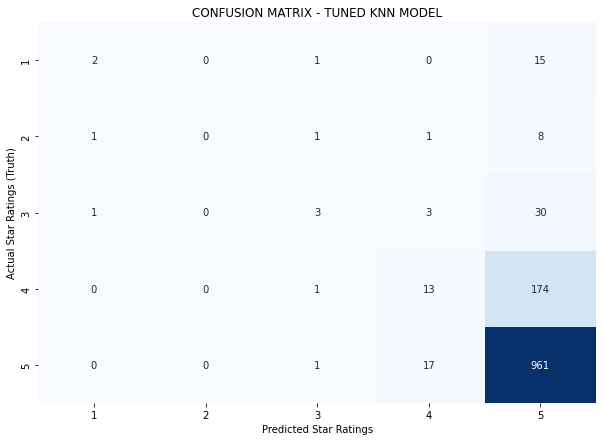

In [33]:
# Predict using the tuned model
grid_predictions = h_grid.predict(X_test_vect.toarray())
 
# print classification report
print(classification_report(y_test, grid_predictions, zero_division=0))

# Show the hamming loss
print(f'Hamming loss: {hamming_loss(y_test, grid_predictions)}')

# Show the log-loss
grid_probs = h_grid.predict_proba(X_test_vect.toarray())
print(f'Log loss: {log_loss(y_test, grid_probs)}')

print('\n\n')

# Show the confusion matrix
cm = confusion_matrix(y_test, grid_predictions)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5], fmt='d', cbar=False)
plt.xlabel('Predicted Star Ratings')
plt.ylabel('Actual Star Ratings (Truth)')
plt.title('CONFUSION MATRIX - TUNED KNN MODEL')
plt.show()

In [34]:
print(h_grid.best_params_)

{'leaf_size': 5, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}


<hr>

# <u> NLP TASK 2 : </u>

## DBSCAN and LDA

#### Get reviews for each product

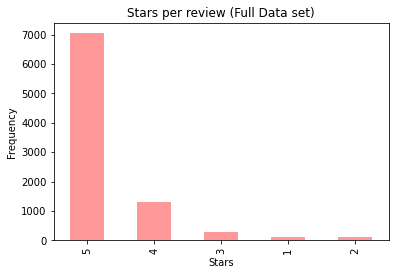

In [39]:
# Use the full dataset : master_df_cleaned

# Filter the columns we want
review_columns = ['ID','Review_num', 'Review_star_count','Review_customer_name','Review_date','Review_title','Review_text','Review_originally_posted']
reviews_df = master_df_cleaned.filter(items=review_columns)
reviews_df = restore_reviews(reviews_df)
columns_to_join = ['Review_title','Review_text','Review_originally_posted']
reviews_df = combine_columns(reviews_df, columns_to_join)

# Plot distribution of reviews among star counts - not sure if needed ??
reviews_df['Review_star_count'].value_counts().plot(kind='bar', alpha=0.4, color='r', title='Stars per review (Full Data set)', xlabel="Stars", ylabel="Frequency")
plt.show()

### TEXT PRE-PROCESSING

In [42]:
reviews_unigrams = pre_process(reviews_df, 'text', n_grams=1, rejoin=True, pos_filter = True)
X = reviews_unigrams['text']
print(X)

0       terrible panel quality samsung inch attached p...
1       great option quality functionality week super ...
2       samsung uhd samsung tv happy samsung ch soundb...
3       product great love navigation control easy int...
4       great grade color excellent picture clarity gr...
                              ...                        
8828    mid range feature sceptical purchase scepticis...
8829    disappointed terrible tinny sound samsung aust...
8830    amazing picture quality sound terrible good pr...
8831    australian model airplay caravan belief availa...
8832    great great many great function picture clear ...
Name: text, Length: 8833, dtype: object


### VECTORIZATION and DIMENSIONALITY REDUCTION

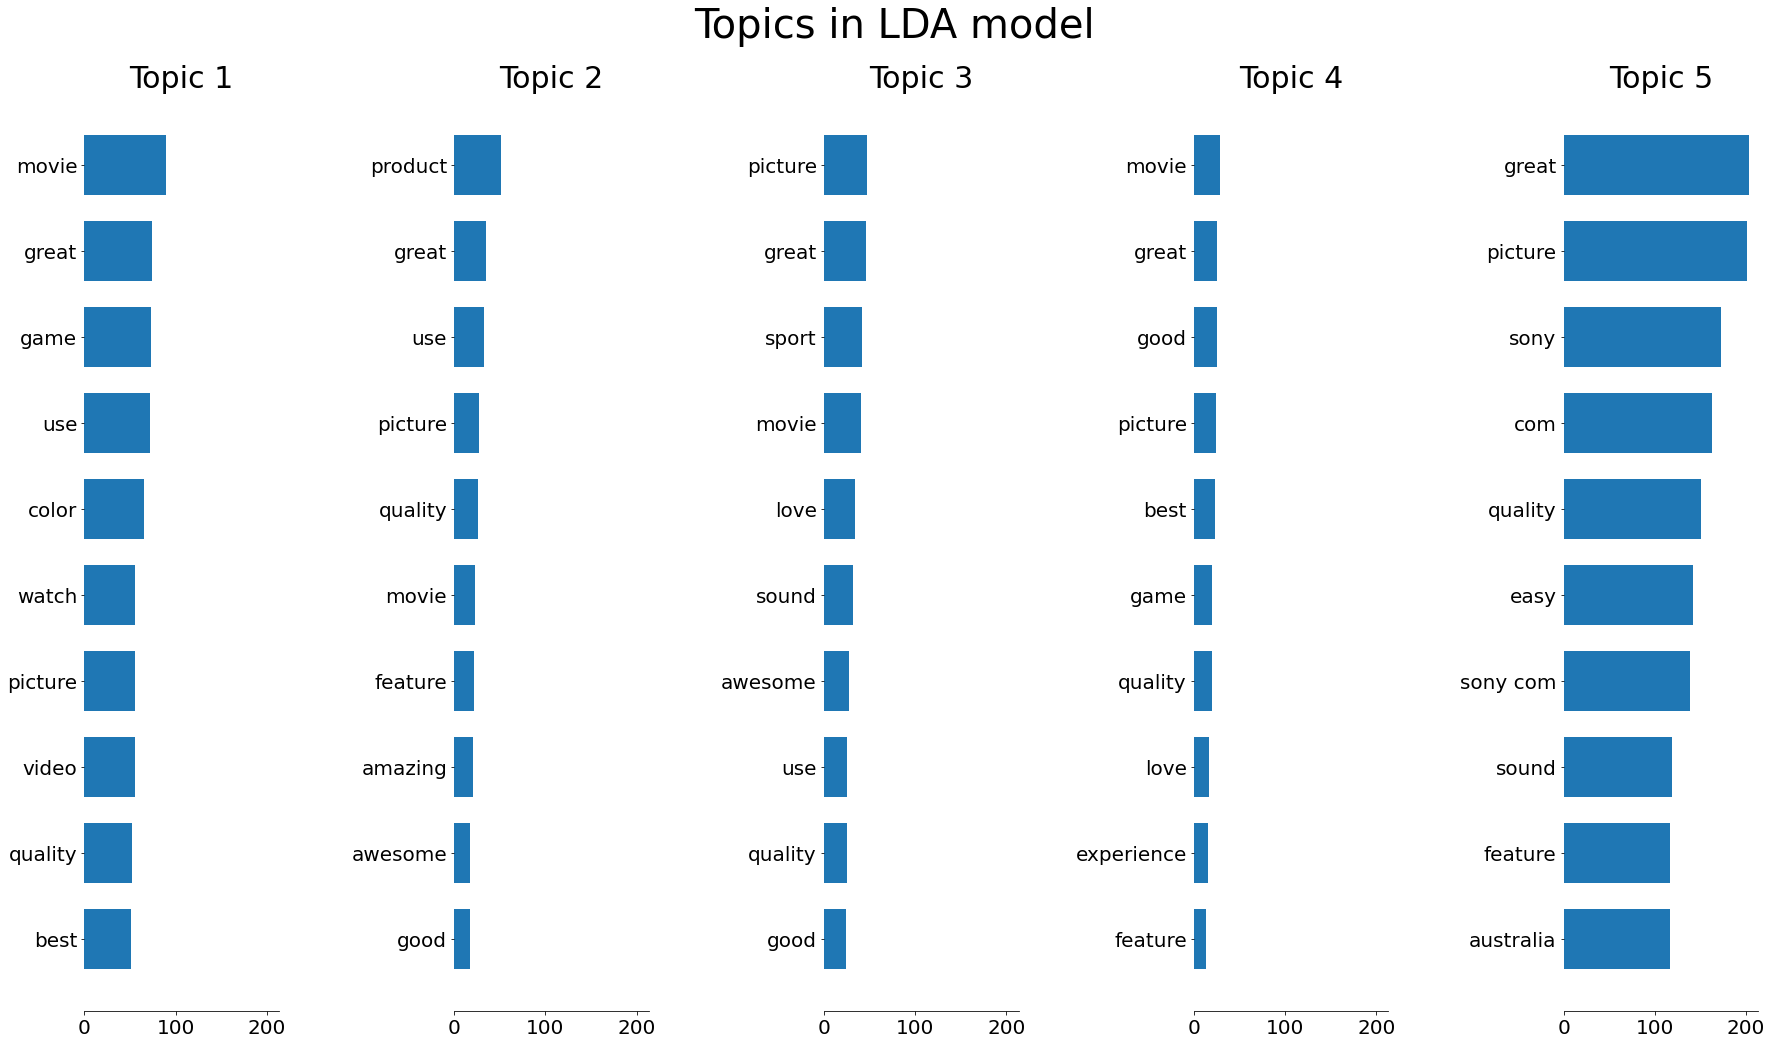

In [43]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1, 2), stop_words='english', max_features=10000)
X_vect = vectorizer.fit_transform(X)
vocab = vectorizer.get_feature_names_out()

lda_model = lda(n_components=5, n_jobs=-1, random_state=19, max_iter = 10, verbose = 0)
X_topics = lda_model.fit_transform(X_vect)

# Plot the top 10 words from each topic within the group
n_top_words = 10
plot_top_words(lda_model, vocab, n_top_words, f'Topics in LDA model')





# Dimensionality reduction using truncated SVD (aka LSA).
#svd_model = TruncatedSVD(n_components=50)
#svd_tfidf = svd_model.fit_transform(X_vect)

# Dimensionality reduction using UMAP
#umap_model = umap.UMAP(n_components=2, n_neighbors = 10)

# Plot the network using Hammer edge bundling - can take a while to compute (eg. 10 minutes)
#mapper = umap_model.fit(svd_tfidf)
#umap.plot.connectivity(mapper, edge_bundling='hammer')

# Fit and transform the umap model to the truncated SVD / TF-IDF data
#umap_tfidf = umap_model.fit_transform(svd_tfidf)
#umap_tfidf = mapper.transform(svd_tfidf)

In [44]:
X_topic_label = [(np.argmax(a)+1) for a in X_topics]

print(X_topics[0], X_topic_label[0], X[0])
print(X_topics[1], X_topic_label[1], X[1])
print(X_topics[2], X_topic_label[2], X[2])

[0.04044555 0.03830492 0.84278482 0.03849825 0.03996645] 3 terrible panel quality samsung inch attached picture simple white background show uniformity white color black background horrible huge wall expert samsung
[0.03248602 0.25369262 0.0317862  0.03130211 0.65073304] 5 great option quality functionality week super impressed purchase great picture colour brightness hz refresh rate available match output new p smooth image happy samsung australia
[0.03540233 0.31570965 0.03439062 0.03425973 0.58023768] 5 samsung uhd samsung tv happy samsung ch soundbar happy samsung product phone tablet tv soundbars fourth samsung tv performed great samsung tv house easier house samsung australia


In [53]:
UMAP_df = pd.DataFrame({'X': X, 'Topic_Number': X_topic_label})
UMAP_df

,X,Topic_Number
0,terrible panel quality samsung inch attached p...,3
1,great option quality functionality week super ...,5
2,samsung uhd samsung tv happy samsung ch soundb...,5
3,product great love navigation control easy int...,5
4,great grade color excellent picture clarity gr...,2
...,...,...
8828,mid range feature sceptical purchase scepticis...,5
8829,disappointed terrible tinny sound samsung aust...,5
8830,amazing picture quality sound terrible good pr...,3
8831,australian model airplay caravan belief availa...,5


C:\Users\scott.collier\Anaconda3\lib\site-packages\umap\plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

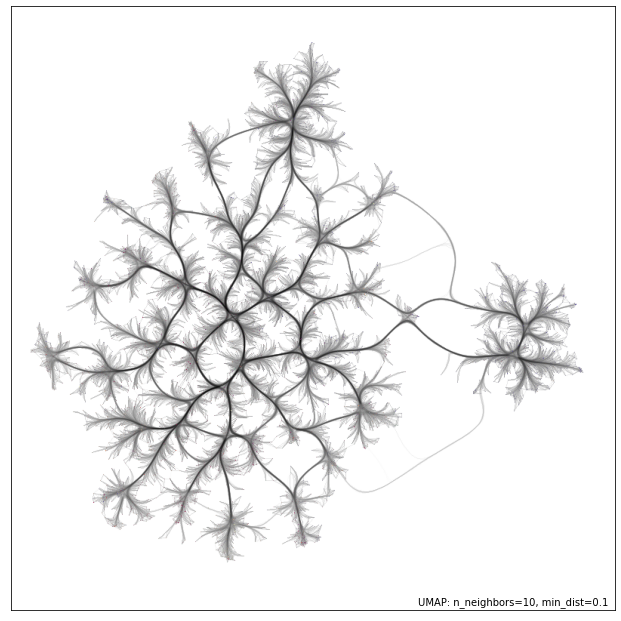

In [52]:
# Dimensionality reduction using truncated SVD (aka LSA).
svd_model = TruncatedSVD(n_components=50)
svd_tfidf = svd_model.fit_transform(X_vect)

# Dimensionality reduction using UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors = 10)

# Plot the network using Hammer edge bundling - can take a while to compute (eg. 10 minutes)
mapper = umap_model.fit(svd_tfidf)
umap.plot.connectivity(
    mapper, 
    edge_bundling="hammer",
    cmap="rainbow",
    labels=UMAP_df['Topic_Number'],
    show_points=True,
 )

C:\Users\scott.collier\Anaconda3\lib\site-packages\umap\plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

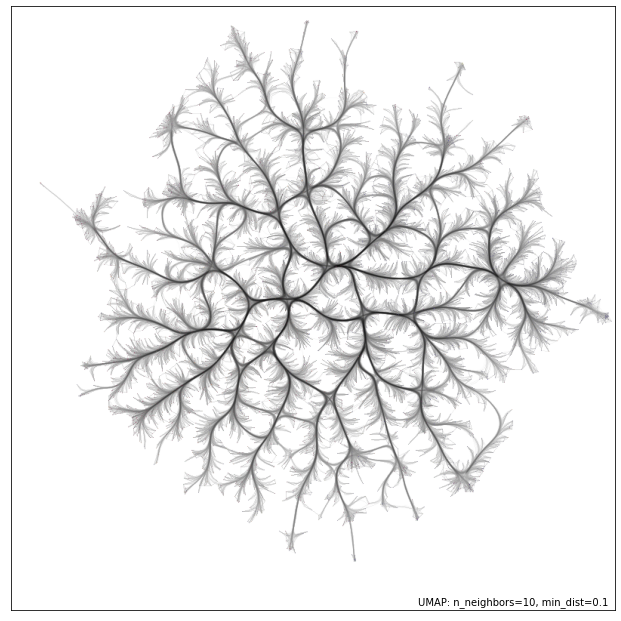

In [54]:
# Dimensionality reduction using UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors = 10)

# Plot the network using Hammer edge bundling - can take a while to compute (eg. 10 minutes)
mapper = umap_model.fit(X_vect)
umap.plot.connectivity(
    mapper, 
    edge_bundling="hammer",
    cmap="rainbow",
    labels=UMAP_df['Topic_Number'],
    show_points=True,
 )